# Blindness Detection Notebook

#### Le but de ce travail est de classifier une image de la rétine selon la séverité de la rétinopathie (0-4), le dataset utilisé est *APTOS 2019 Blindness Detection* avec plus de 3600 images d'entraînement et 1900 images de test.


## 1-Importation

In [12]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator






## Chemins d'accès 

In [15]:
csv_path = '/kaggle/input/aptos2019-blindness-detection/train.csv'
img_dir = '/kaggle/input/aptos2019-blindness-detection/train_images'


## Data Augmentation (à faire)

In [ ]:
####

In [16]:
# Define input shape
input_shape = (224, 224, 3)

# Load base model without the top classification layers
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))

# Freeze the base model layers to prevent them from being updated during training
base_model.trainable = False

# Add custom classification layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(5, activation='softmax')(x)  # 5 output classes for DR levels

# Create the final model
model = Model(inputs=base_model.input, outputs=output)

# Show model structure
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,214,184 (16.08 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

## Entraînement du modèle précedent et affichage des métriques 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - accuracy: 0.5887 - auc: 0.8205 - loss: 1.2689 - precision: 0.6943 - recall: 0.5050 - val_accuracy: 0.7040 - val_auc: 0.9129 - val_loss: 0.8541 - val_precision: 0.8350 - val_recall: 0.5866
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.7164 - auc: 0.9218 - loss: 0.7920 - precision: 0.8300 - recall: 0.6209 - val_accuracy: 0.7299 - val_auc: 0.9212 - val_loss: 0.7877 - val_precision: 0.8297 - val_recall: 0.6180
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.7392 - auc: 0.9388 - loss: 0.6986 - precision: 0.8246 - recall: 0.6542 - val_accuracy: 0.7271 - val_auc: 0.9252 - val_loss: 0.7746 - val_precision: 0.8085 - val_recall: 0.6453
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.7394 - auc: 0.9336 - loss: 0.7261 - precision: 0.8237 - recall: 0.6557 - val_accuracy: 0.7271 - val_auc: 0.9248 - val_loss: 0.7867 - val_precision: 0.8168 - val_recall: 0.6385
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s

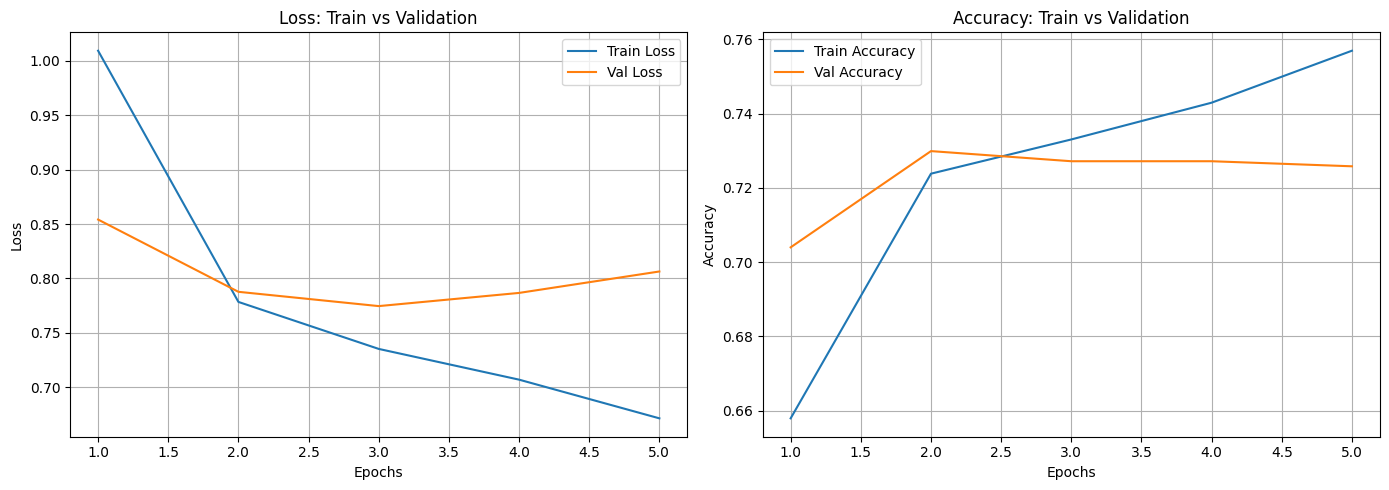

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


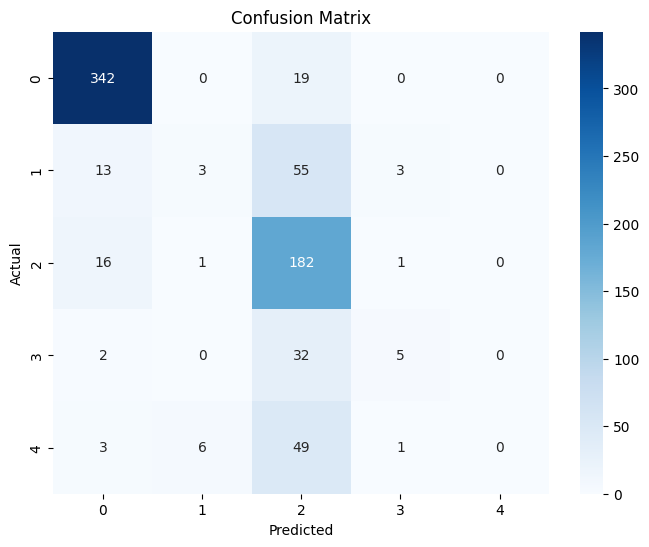

In [17]:


# Paths
csv_path = '/kaggle/input/aptos2019-blindness-detection/train.csv'
img_dir = '/kaggle/input/aptos2019-blindness-detection/train_images'

# Load labels
df = pd.read_csv(csv_path)
df['image_id'] = df['id_code'].apply(lambda x: os.path.join(img_dir, f"{x}.png"))

# Basic constants
IMG_SIZE = 224
NUM_CLASSES = 5

# Load and preprocess images
def load_images(df, img_size=IMG_SIZE):
    images = []
    labels = []
    for _, row in df.iterrows():
        img_path = row['image_id']
        label = row['diagnosis']
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (img_size, img_size))
            img = img / 255.0  # normalize
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)

# Load image data
images, labels = load_images(df)

# Train/val split
x_train, x_val, y_train, y_val = train_test_split(
    images, labels, test_size=0.2, stratify=labels, random_state=42
)

# One-hot encode labels
y_train_oh = to_categorical(y_train, NUM_CLASSES)
y_val_oh = to_categorical(y_val, NUM_CLASSES)

# Define a simple CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax')
])

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
)

# Train model
history = model.fit(
    x_train, y_train_oh,
    epochs=5,
    batch_size=32,
    validation_data=(x_val, y_val_oh)
)

# Plot combined loss and accuracy
def plot_combined_loss_accuracy(history):
    epochs = range(1, len(history.history['loss']) + 1)

    plt.figure(figsize=(14, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], label='Train Loss')
    plt.plot(epochs, history.history['val_loss'], label='Val Loss')
    plt.title('Loss: Train vs Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['accuracy'], label='Train Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy: Train vs Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('combined_loss_accuracy_plot.png')
    plt.savefig('combined_loss_accuracy_plot.svg')

    plt.show()

plot_combined_loss_accuracy(history)

# Plot confusion matrix
def plot_confusion_matrix(model, x_val, y_val):
    y_pred_probs = model.predict(x_val)
    y_pred = np.argmax(y_pred_probs, axis=1)
    cm = confusion_matrix(y_val, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig('confusion_matrix.png')
    plt.show()

plot_confusion_matrix(model, x_val, y_val)


## Même Code avec accelèration GPU 

In [ ]:


# ====== GPU SETUP ======
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"{len(gpus)} GPU(s) available and memory growth set.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU available. Running on CPU.")

# ====== PATHS ======
csv_path = '/kaggle/input/aptos2019-blindness-detection/train.csv'
img_dir = '/kaggle/input/aptos2019-blindness-detection/train_images'

# ====== LOAD LABELS ======
df = pd.read_csv(csv_path)
df['image_id'] = df['id_code'].apply(lambda x: os.path.join(img_dir, f"{x}.png"))

# ====== CONSTANTS ======
IMG_SIZE = 224
NUM_CLASSES = 5

# ====== LOAD & PREPROCESS IMAGES ======
def load_images(df, img_size=IMG_SIZE):
    images = []
    labels = []
    for _, row in df.iterrows():
        img_path = row['image_id']
        label = row['diagnosis']
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (img_size, img_size))
            img = img / 255.0  # normalize
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)

images, labels = load_images(df)

# ====== TRAIN-VAL SPLIT ======
x_train, x_val, y_train, y_val = train_test_split(
    images, labels, test_size=0.2, stratify=labels, random_state=42
)

y_train_oh = to_categorical(y_train, NUM_CLASSES)
y_val_oh = to_categorical(y_val, NUM_CLASSES)

# ====== SIMPLE CNN MODEL ======
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
)

# ====== TRAIN MODEL ======
history = model.fit(
    x_train, y_train_oh,
    epochs=5,
    batch_size=64,
    validation_data=(x_val, y_val_oh)
)

# ====== PLOT LOSS & ACCURACY ======
def plot_combined_loss_accuracy(history):
    epochs = range(1, len(history.history['loss']) + 1)
    plt.figure(figsize=(14, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], label='Train Loss')
    plt.plot(epochs, history.history['val_loss'], label='Val Loss')
    plt.title('Loss: Train vs Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['accuracy'], label='Train Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy: Train vs Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('combined_loss_accuracy_plot.png')
    plt.savefig('combined_loss_accuracy_plot.svg')
    plt.show()

plot_combined_loss_accuracy(history)

# ====== CONFUSION MATRIX ======
def plot_confusion_matrix(model, x_val, y_val):
    y_pred_probs = model.predict(x_val)
    y_pred = np.argmax(y_pred_probs, axis=1)
    cm = confusion_matrix(y_val, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig('confusion_matrix.png')
    plt.savefig('confusion_matrix.svg')
    plt.show()

plot_confusion_matrix(model, x_val, y_val)


## Aperçu d'une image 

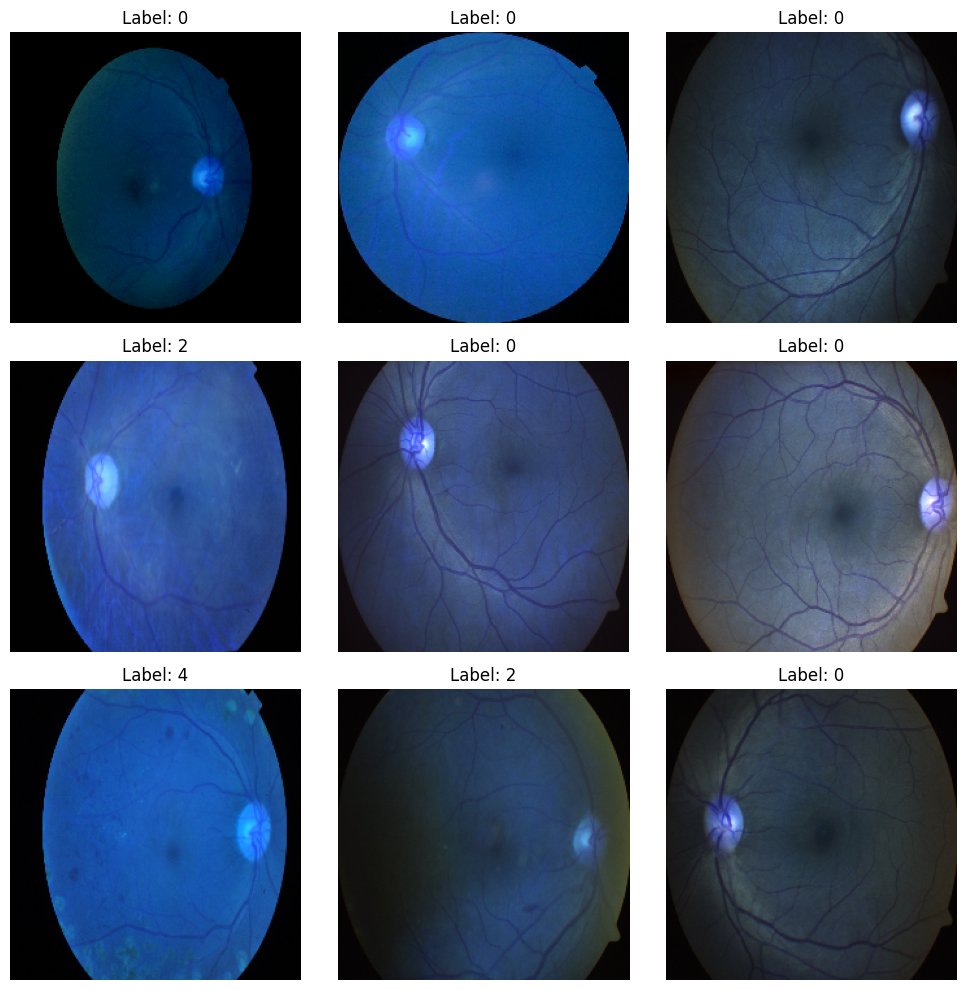

In [18]:


# Mélange aléatoire des indices
indices = np.random.permutation(len(x_train))

# Affichage de 9 images mélangées avec leurs labels
plt.figure(figsize=(10, 10))
for i in range(9):
    idx = indices[i]
    plt.subplot(3, 3, i + 1)

    plt.imshow(x_train[idx])

    # Affichage du label
    label = np.argmax(y_train[idx]) if len(y_train[idx].shape) > 0 else y_train[idx]

    plt.title(f"Label: {label}")
    plt.axis('off')

plt.tight_layout()
plt.show()


## Couches visibles et cachées du modèle

In [19]:
# Filtrer et afficher uniquement les couches cachées
for layer in model.layers:
    if 'input' not in layer.name and 'output' not in layer.name:
        try:
            # Essayer d'afficher la forme de sortie
            output_shape = layer.output.shape
        except AttributeError:
            output_shape = "N/A"
        
        print(f"Layer Name: {layer.name}")
        print(f"Layer Type: {layer.__class__.__name__}")
        print(f"Output Shape: {output_shape}")
        print(f"Trainable Parameters: {layer.count_params()}")
        print("-" * 50)


Layer Name: conv2d_1
Layer Type: Conv2D
Output Shape: (None, 222, 222, 32)
Trainable Parameters: 896
--------------------------------------------------
Layer Name: max_pooling2d_1
Layer Type: MaxPooling2D
Output Shape: (None, 111, 111, 32)
Trainable Parameters: 0
--------------------------------------------------
Layer Name: flatten_1
Layer Type: Flatten
Output Shape: (None, 394272)
Trainable Parameters: 0
--------------------------------------------------
Layer Name: dense_4
Layer Type: Dense
Output Shape: (None, 128)
Trainable Parameters: 50466944
--------------------------------------------------
Layer Name: dense_5
Layer Type: Dense
Output Shape: (None, 5)
Trainable Parameters: 645
--------------------------------------------------


## Prédiction sur Image aléatoire

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 951ms/step


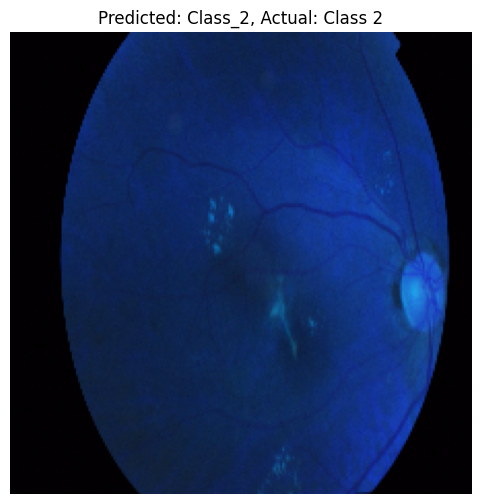

Predicted Class: Class_2
Actual Class: 2


In [20]:



# Function to load and preprocess a random image from the dataset
def load_random_image(df, img_dir, img_size=224):
    # Select a random index from the dataset
    random_index = random.randint(0, len(df) - 1)
    
    # Get the image path and the label
    img_path = df.iloc[random_index]['image_id']
    label = df.iloc[random_index]['diagnosis']
    
    # Load and preprocess the image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (img_size, img_size))  # Resize image
    img = img / 255.0  # Normalize image to [0, 1]
    
    return img, label, img_path

# Load a random image from the dataset
img, label, img_path = load_random_image(df, img_dir)

# Add batch dimension for prediction (model expects a batch of images)
img_input = np.expand_dims(img, axis=0)

# Make a prediction
preds = model.predict(img_input)

# Get the predicted class
predicted_class = np.argmax(preds)

# Map the predicted class back to its label (assuming 0-4 labels for diagnosis)
class_names = ['Class_0', 'Class_1', 'Class_2', 'Class_3', 'Class_4']  # replace with actual class names if available
predicted_class_name = class_names[predicted_class]

# Plot the image and its predicted class
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.title(f"Predicted: {predicted_class_name}, Actual: Class {label}")
plt.axis('off')
plt.show()

print(f"Predicted Class: {predicted_class_name}")
print(f"Actual Class: {label}")


## Carte d'activation (GRADCAM)

In [ ]:
## A FAIRE DEMAIN !